In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [3]:
train_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/first/"
test_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/test/"

In [4]:
batch_size = 32

train_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
train_data = ImageFolder(train_image_path, transform = train_trans)
train_loader = DataLoader(train_data, num_workers = 2, batch_size = batch_size, shuffle = True, pin_memory = True)

test_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data)

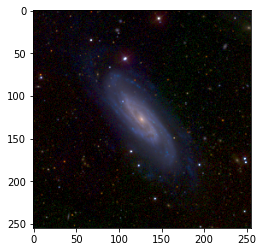

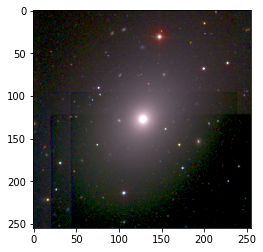

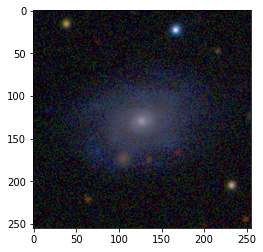

In [5]:
images, labels = next(iter(train_loader))

for i in np.arange(3):
  plt.figure(i)
  plt.imshow(images[i].permute(1, 2, 0))
  plt.show()

In [6]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Galaxy(nn.Module):
  def __init__(self):
    super(Galaxy, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
        ## CNN5
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
    )
    self.fc = nn.Sequential(
        nn.Linear(512 * 7 * 7, 128), # Fully-connected layer
        nn.Dropout(0.25), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.Dropout(0.4),
        nn.ReLU(),
        nn.Linear(128, 3)
    )
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    x = x.flatten(1)
    x = self.fc(x)
    return x

In [7]:
model = Galaxy()
model = model.to(device)
print(model)

Galaxy(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25088, out_features=128, bias=Tru

In [8]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.CrossEntropyLoss()

n_epochs = 30
train_loss_record = []
train_acc_record = []
for epoch in range(n_epochs):
  train_loss = 0.0
  train_acc = 0.0
  model.train()

  for x, y in tqdm(train_loader):
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    train_acc += acc/len(train_loader)
    train_loss += loss/len(train_loader)

  print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
  train_loss_record.append(train_loss)
  train_acc_record.append(train_acc)
torch.save(model, 'catvsdog.pkl')

  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/chisc/.pyenv/versions/torch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[ Train | 1/30 ] loss = 1.03793, acc = 0.55949


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 2/30 ] loss = 0.97975, acc = 0.56335


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 3/30 ] loss = 0.76123, acc = 0.64890


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 4/30 ] loss = 0.62706, acc = 0.73752


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 5/30 ] loss = 0.49124, acc = 0.81955


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 6/30 ] loss = 0.42939, acc = 0.86035


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 7/30 ] loss = 0.37224, acc = 0.87309


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 8/30 ] loss = 0.31510, acc = 0.89670


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 9/30 ] loss = 0.27380, acc = 0.92345


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 10/30 ] loss = 0.26958, acc = 0.91563


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 11/30 ] loss = 0.25253, acc = 0.92268


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 12/30 ] loss = 0.22248, acc = 0.93109


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 13/30 ] loss = 0.21322, acc = 0.93907


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 14/30 ] loss = 0.19220, acc = 0.94005


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 15/30 ] loss = 0.16277, acc = 0.95410


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 16/30 ] loss = 0.15660, acc = 0.95470


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 17/30 ] loss = 0.13820, acc = 0.95508


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 18/30 ] loss = 0.23743, acc = 0.92756


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 19/30 ] loss = 0.17794, acc = 0.94710


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 20/30 ] loss = 0.13851, acc = 0.95898


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 21/30 ] loss = 0.11672, acc = 0.95763


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 22/30 ] loss = 0.10609, acc = 0.96641


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 23/30 ] loss = 0.10511, acc = 0.96777


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 24/30 ] loss = 0.07568, acc = 0.97559


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 25/30 ] loss = 0.08277, acc = 0.97130


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 26/30 ] loss = 0.06425, acc = 0.98009


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 27/30 ] loss = 0.10419, acc = 0.96506


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 28/30 ] loss = 0.07499, acc = 0.97461


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 29/30 ] loss = 0.04880, acc = 0.98340


  0%|          | 0/32 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[ Train | 30/30 ] loss = 0.05555, acc = 0.98340


In [10]:
model.eval()
for x, y in test_loader:
  x, y = x.to(device), y.to(device)
  prediction = model(x)
  loss = loss_func(prediction, y)
  loss.backward()
  acc = ((prediction.argmax(dim = 1) == y).float().mean())
print(f"[ Test ] loss = {loss:.5f}, acc = {acc:.5f}")

[ Test ] loss = 0.10492, acc = 1.00000


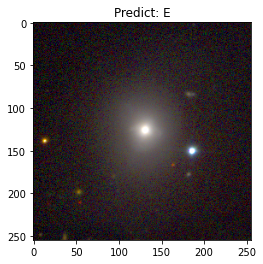

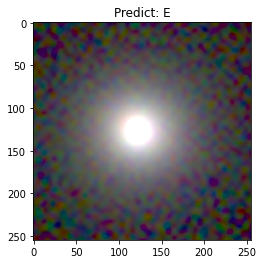

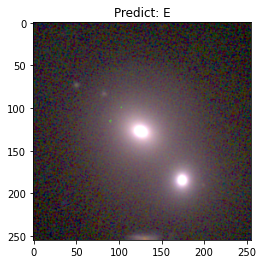

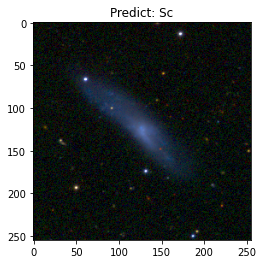

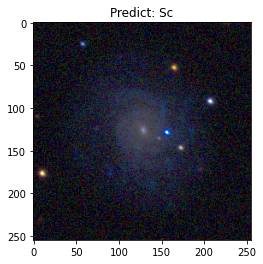

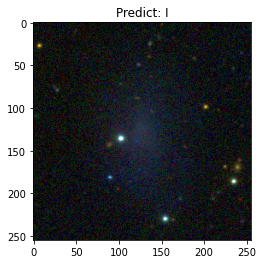

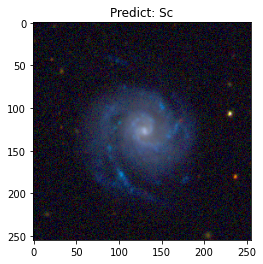

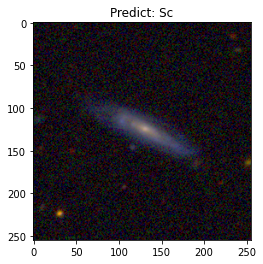

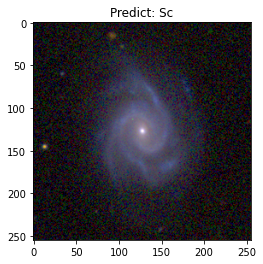

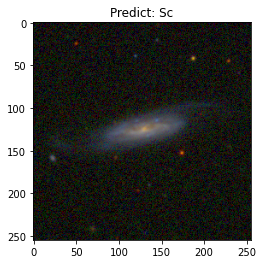

In [12]:
i = 0
for x, y in test_loader:
  i += 1
  if train_on_gpu:
    x, y = x.cuda(), y.cuda()
  output = model(x)
  out = output.argmax(dim = 1)
  out = out.to('cpu').numpy()
  # print(out)
  if i % 10 == 0:
    plt.figure(i)
    if out[0] == 0:
      plt.title('Predict: E')
    elif out[0] == 1:
      plt.title('Predict: I')
    else:
      plt.title('Predict: Sc')
    x = x.squeeze()
    x = x.to('cpu')
    plt.imshow(x.permute(1, 2, 0))
    plt.show()

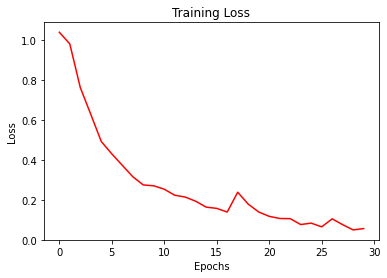

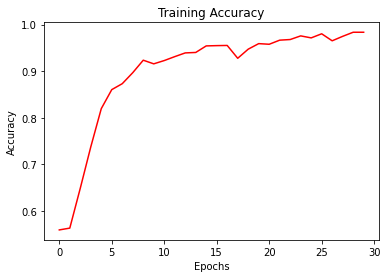

In [13]:
plt.figure(1)
plt.title('Training Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(2)
plt.title('Training Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()